# Introduction
This is a project to get more familiar with the classical machine learning technique of random forests and decision trees. The project aims to be able to classify athletes based on their height, weight, gender and age into whether they compete in the summer or winter olympics. The dataset is sourced from Kaggle.

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.facecolor'] = 'white'
import seaborn as sns
from tqdm import tqdm

## 1. Exploratory Data Analysis

In [3]:
raw_data = pd.read_csv("data/athlete_events.csv", index_col=0)
raw_data.head()

,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
ID,,,,,,,,,,,,,,
1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NaN
2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NaN
3,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,NaN
4,Edgar Lindenau Aabye,M,34.0,NaN,NaN,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold
5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,NaN


In [17]:
noc_regions = pd.read_csv("data/noc_regions.csv", index_col=0)
noc_regions.head()

,region,notes
NOC,,
AFG,Afghanistan,NaN
AHO,Curacao,Netherlands Antilles
ALB,Albania,NaN
ALG,Algeria,NaN
AND,Andorra,NaN


In [4]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 271116 entries, 1 to 135571
Data columns (total 14 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Name    271116 non-null  object 
 1   Sex     271116 non-null  object 
 2   Age     261642 non-null  float64
 3   Height  210945 non-null  float64
 4   Weight  208241 non-null  float64
 5   Team    271116 non-null  object 
 6   NOC     271116 non-null  object 
 7   Games   271116 non-null  object 
 8   Year    271116 non-null  int64  
 9   Season  271116 non-null  object 
 10  City    271116 non-null  object 
 11  Sport   271116 non-null  object 
 12  Event   271116 non-null  object 
 13  Medal   39783 non-null   object 
dtypes: float64(3), int64(1), object(10)
memory usage: 31.0+ MB


As expected, the `Medals` column has nulls as not all athletes would win a medal. There are also nulls in the `Age`, `Height` and `Weight` columns. It would make sense that if the `Height` column is null, the `Weight` column would also be null. If that is true, we can just drop these rows. If not, we could explore whether the athelete for whom the data is missing has any other entires in the dataset where the data is not missing.

In [5]:
#Find the indices of the null rows in the Height column and intersect with the same on the Weight column
same_index_na = len(set(raw_data[raw_data["Height"].isna()].index).intersection(raw_data[raw_data["Weight"].isna()].index))

n_height_na = len(raw_data[raw_data["Height"].isna()])
n_weight_na = len(raw_data[raw_data["Weight"].isna()])

print(f"Out of {n_height_na} rows of missing height data and {n_weight_na} of missing weight data, {same_index_na} are the same row")


Out of 60171 rows of missing height data and 62875 of missing weight data, 32817 are the same row


More than half of the rows where the `Height` is missing, the `Weight` is too. There is definitely a case to drop the intersecting indices. As for the non intersecting indices, while we could search the dataset for other entires for the same athletes, there is no guarantee that their weight (and even their height) would stay the same across Olympics'. Given the large dataset, I am comfortable dropping all rows with NaNs in the `Height` and `Weight` columns.

In [6]:
data_dropped_hw_na = raw_data[(~raw_data["Height"].isna()) & (~raw_data["Weight"].isna())].reset_index(drop=True)
data_dropped_hw_na.head()

,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
0,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NaN
1,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NaN
2,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,NaN
3,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,"Speed Skating Women's 1,000 metres",NaN
4,Christine Jacoba Aaftink,F,25.0,185.0,82.0,Netherlands,NED,1992 Winter,1992,Winter,Albertville,Speed Skating,Speed Skating Women's 500 metres,NaN


We still have a dataset with more than 200,000 entires. Lets see how many reaiming rows are missing `Age` data. 

In [7]:
age_na = len(data_dropped_hw_na[data_dropped_hw_na["Age"].isna()])
print(f"{age_na} rows still have missing data for Age")

688 rows still have missing data for Age


Given that such a small number of rows with missing data remain, we could drop them. However, I am interested to see if the athletes with missing age data have populated data elsewhere in the dataset.

In [8]:
for athlete in (data_dropped_hw_na[data_dropped_hw_na["Age"].isna()]["Name"].unique()):

    athlete_all_entires = data_dropped_hw_na[data_dropped_hw_na["Name"] == athlete]

    if len(athlete_all_entires[~athlete_all_entires["Age"].isna()]) > 0:
        print(athlete_all_entires[["Name","Age","Games","Team"]])
    
    

                        Name   Age        Games    Team
39868  Dimitrios Deligiannis  22.0  1984 Summer  Greece
39869  Dimitrios Deligiannis  26.0  1988 Summer  Greece
39870  Dimitrios Deligiannis  30.0  1992 Summer  Greece
39871  Dimitrios Deligiannis   NaN  1896 Summer  Greece
                 Name   Age        Games        Team
41164  Mamadou Diallo   NaN  1984 Summer  Mauritania
41165  Mamadou Diallo  38.0  1980 Summer      Guinea
41166  Mamadou Diallo  29.0  1984 Summer     Senegal
               Name   Age        Games         Team
90082  Kim Yong-Bae   NaN  1968 Summer  South Korea
90083  Kim Yong-Bae  22.0  1996 Summer  South Korea
90084  Kim Yong-Bae  26.0  2000 Summer  South Korea
90085  Kim Yong-Bae  30.0  2004 Summer  South Korea
90086  Kim Yong-Bae  34.0  2008 Summer  South Korea


For all but 3 athletes, there are no other instances of their age in the dataset (unless they changed their name between games). There are ages recorded for 3 athletes, however for all of them the athlete with populated data is clearly different from the athlete with populated data. In the case of Mamadou Diallo, the populated data athlete is competing for Senegal, wheras the unpopulated data athlete is competeing for Mauritiania. All that work to save no rows of data, but interesting to see nonetheless. Lets drop all rows where `Age` is NaN.

In [9]:
data_no_na = data_dropped_hw_na[~data_dropped_hw_na["Age"].isna()]
data_no_na.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 206165 entries, 0 to 206852
Data columns (total 14 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Name    206165 non-null  object 
 1   Sex     206165 non-null  object 
 2   Age     206165 non-null  float64
 3   Height  206165 non-null  float64
 4   Weight  206165 non-null  float64
 5   Team    206165 non-null  object 
 6   NOC     206165 non-null  object 
 7   Games   206165 non-null  object 
 8   Year    206165 non-null  int64  
 9   Season  206165 non-null  object 
 10  City    206165 non-null  object 
 11  Sport   206165 non-null  object 
 12  Event   206165 non-null  object 
 13  Medal   30181 non-null   object 
dtypes: float64(3), int64(1), object(10)
memory usage: 23.6+ MB


The remaining dataset has 206,165 entires. That is enough to train a Random Forest on. Many rows in this dataset, however, are the same athlete. As we are trying to classify the sport an athlete plays based on some metrics it is valid that now all rows in the database are unique. An athlete may play more than two sports, and changes in weight and height across time for the same athlete will add some variance to the dataset.

In [42]:
print(f"There are {data_no_na.Sport.nunique()} sports in this dataset")
data_no_na.Sport.value_counts().tail()

There are 56 sports in this dataset


Rugby               30
Art Competitions    28
Tug-Of-War          20
Lacrosse             2
Motorboating         1
Name: Sport, dtype: int64

Lets drop any sports which have less than a 1000 athletes worth of data as it would be difficult to train the algorithm for these states.

In [48]:
data_sparse_sports_removed = data_no_na[data_no_na.groupby('Sport').Sport.transform('count')>1000].copy()

There are lots of other ways in which we can clean the data, for example by considering temporal conditions for validity, or even dropping all but the top few sports. In this case I am very aware that the features we have are not enough to get good accuracy in the model. This is a learning project, so lets carry on anyways.

We cannot use the `Team` column to infer what country an athlete is competing for, so we have to join in the NOC regions. We will use an `inner join` so as to discard any rows without a corresponding NOC region.

In [49]:
joined_data = pd.merge(data_sparse_sports_removed, noc_regions, on="NOC")
joined_data.head()

,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal,region,notes
0,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NaN,China,NaN
1,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NaN,China,NaN
2,Abudoureheman,M,22.0,182.0,75.0,China,CHN,2000 Summer,2000,Summer,Sydney,Boxing,Boxing Men's Middleweight,NaN,China,NaN
3,Ai Linuer,M,25.0,160.0,62.0,China,CHN,2004 Summer,2004,Summer,Athina,Wrestling,"Wrestling Men's Lightweight, Greco-Roman",NaN,China,NaN
4,Ai Yanhan,F,14.0,168.0,54.0,China,CHN,2016 Summer,2016,Summer,Rio de Janeiro,Swimming,Swimming Women's 200 metres Freestyle,NaN,China,NaN


In [50]:
athlete_data = joined_data.drop(columns=["Event","NOC","notes"])
athlete_data.head()

,Name,Sex,Age,Height,Weight,Team,Games,Year,Season,City,Sport,Medal,region
0,A Dijiang,M,24.0,180.0,80.0,China,1992 Summer,1992,Summer,Barcelona,Basketball,NaN,China
1,A Lamusi,M,23.0,170.0,60.0,China,2012 Summer,2012,Summer,London,Judo,NaN,China
2,Abudoureheman,M,22.0,182.0,75.0,China,2000 Summer,2000,Summer,Sydney,Boxing,NaN,China
3,Ai Linuer,M,25.0,160.0,62.0,China,2004 Summer,2004,Summer,Athina,Wrestling,NaN,China
4,Ai Yanhan,F,14.0,168.0,54.0,China,2016 Summer,2016,Summer,Rio de Janeiro,Swimming,NaN,China


Lets do some plotting, I am interested in seeing how the heights and weights vary, wich athletes have the most entires, which countries have the most entires etc.

In [51]:
def format_ax(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_color('#DDDDDD')

    ax.tick_params(left=False)

    ax.set_axisbelow(True)
    ax.yaxis.grid(True, color='#EEEEEE')
    ax.xaxis.grid(False)

Text(0.5, 1.0, 'Height vs Weight of athletes')

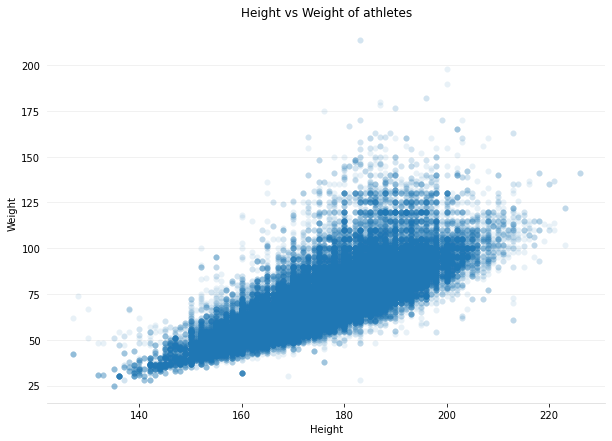

In [53]:
fig,ax = plt.subplots(figsize=(10,7))
sns.scatterplot(data=athlete_data, x= "Height",y = "Weight", ax=ax,alpha=0.1,
                 linewidth = 0)
format_ax(ax)
ax.set_title("Height vs Weight of athletes")

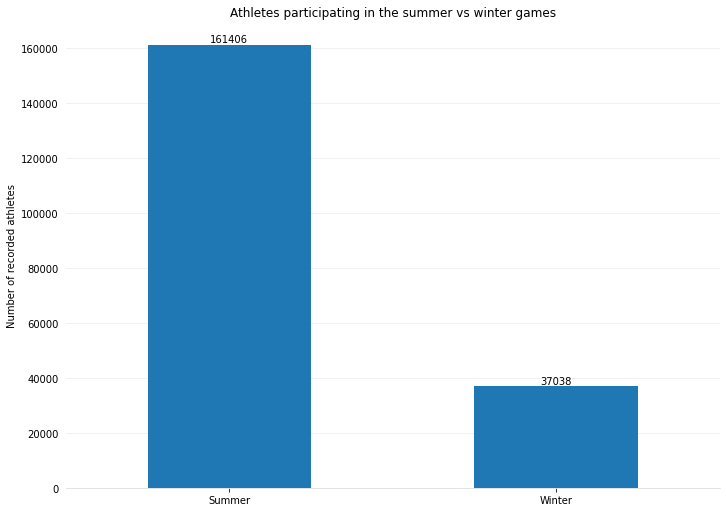

In [113]:
fig,ax = plt.subplots(figsize=(10,7))
athlete_data.Season.value_counts().plot.bar(ax=ax)

for c in ax.containers:

    # Optional: if the segment is small or 0, customize the labels
    labels = [v.get_height() if v.get_height() > 0 else '' for v in c]
    
    rounded_labels = np.around(labels, decimals = 1)
    # remove the labels parameter if it's not needed for customized labels
    ax.bar_label(c, labels=rounded_labels, label_type='edge')

format_ax(ax)
plt.xticks(rotation = 0)
plt.tight_layout()

ax.set_ylabel("Number of recorded athletes")
_ = ax.set_title("Athletes participating in the summer vs winter games")

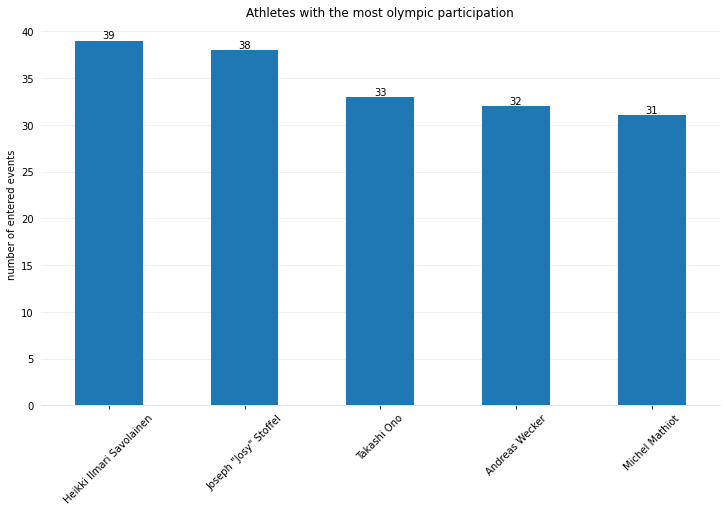

In [65]:
fig,ax = plt.subplots(figsize=(10,7))
athlete_data.Name.value_counts().head().plot.bar(ax=ax)

for c in ax.containers:

    # Optional: if the segment is small or 0, customize the labels
    labels = [v.get_height() if v.get_height() > 0 else '' for v in c]
    
    rounded_labels = np.around(labels, decimals = 1)
    # remove the labels parameter if it's not needed for customized labels
    ax.bar_label(c, labels=rounded_labels, label_type='edge')

format_ax(ax)
plt.xticks(rotation = 45)
plt.tight_layout()

ax.set_ylabel("number of entered events")
_ = ax.set_title("Athletes with the most olympic participation")

In [105]:
num_participated_sports = pd.DataFrame(columns=["Country","Num_sports"])
num_participated_sports.set_index("Country", inplace = True)
for country, country_df in athlete_data.groupby(by="region"):
    num_participated_sports.loc[country] =  country_df.Sport.nunique()

num_participated_sports[num_participated_sports["Num_sports"] > num_participated_sports["Num_sports"].max() - 3].sort_values(by="Num_sports", ascending = False)

,Num_sports
Country,
Canada,37
Czech Republic,37
France,37
Germany,37
Japan,37
Russia,37
USA,37
Italy,36
Poland,36


### Encoding nominal data

The columns of  `Sex`, and `Season` are all nominal and need to be encoded.

In [130]:
athlete_data.Sex.unique()

array(['M', 'F'], dtype=object)

Only two sexes are present in the dataset

In [131]:
athlete_data.Season.unique()

array(['Summer', 'Winter'], dtype=object)

Same with the season. As expected, there are only the winter and summer Olympics

In [141]:
athlete_data_encoded = pd.get_dummies(athlete_data,columns=["Sex","Season"])

# 2. Modelling 

In [179]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report,ConfusionMatrixDisplay

In [144]:
#train on sex, age, height, weight, season, year and region
X = athlete_data_encoded.drop(columns=["Name","Sport","City","Medal","Games","Team","region", "Season_Summer","Season_Winter"])
X.head()

,Age,Height,Weight,Year,Sex_F,Sex_M
0,24.0,180.0,80.0,1992,0,1
1,23.0,170.0,60.0,2012,0,1
2,22.0,182.0,75.0,2000,0,1
3,25.0,160.0,62.0,2004,0,1
4,14.0,168.0,54.0,2016,1,0


In [146]:
y = athlete_data_encoded["Season_Summer"]

In [147]:
#do a test train split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)
X_train.shape, X_test.shape

((138910, 6), (59534, 6))

In [148]:
classifier_rf = RandomForestClassifier(random_state=42, n_jobs=-1, max_depth=5,
                                       n_estimators=100, oob_score=True)


In [149]:
%%time
classifier_rf.fit(X_train, y_train)

CPU times: total: 17 s
Wall time: 4.26 s


RandomForestClassifier(max_depth=5, n_jobs=-1, oob_score=True, random_state=42)

In [152]:
y_pred = classifier_rf.predict(X_test)

In [162]:
accuracy_score(y_test, y_pred)

0.834649108072698

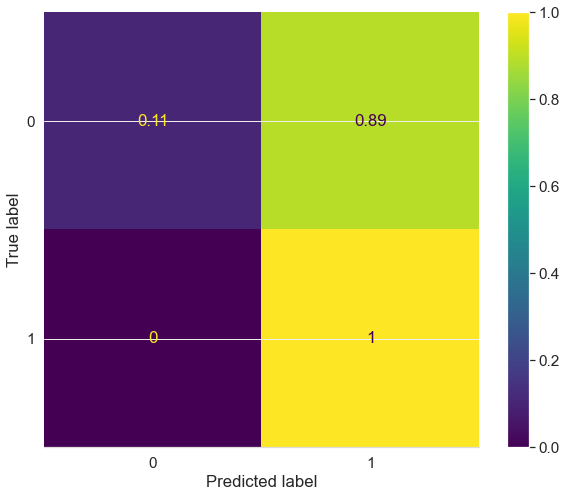

In [188]:
fig, ax = plt.subplots(figsize=(10,8))
matrix = confusion_matrix(y_test, y_pred)

matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

format_ax(ax)
ConfusionMatrixDisplay(confusion_matrix=matrix,display_labels=classifier_rf.classes_).plot(ax=ax)



In [173]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.11      0.20     11049
           1       0.83      1.00      0.91     48485

    accuracy                           0.83     59534
   macro avg       0.92      0.55      0.55     59534
weighted avg       0.86      0.83      0.78     59534

